<a href="https://colab.research.google.com/github/ogsharma/aimoocs/blob/master/MF_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
import os
import matplotlib.pyplot as plt
from sys import stdout

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
tf.__version__

'2.1.0'

In [0]:
import collections
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.3f}'.format

def mask(df, key, function):
    """Returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [0]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
with open('/content/drive/My Drive/user_ratings.csv', 'r') as f:
  ratings = pd.read_csv(f)

with open('/content/drive/My Drive/job_title_mapping.csv', 'r') as f:
    job_title_mapping = pd.read_csv(f)

ratings.columns = ['user_id','job_id','rating']

## Create User ID and Job ID Mapping (For using a sparse matrix representation)

user_id_mapping = {}

for idx,uid in enumerate(list(ratings.user_id.unique())):
    user_id_mapping[uid] = idx

job_id_mapping = {}

for idx,uid in enumerate(list(ratings.job_id.unique())):
    job_id_mapping[uid] = idx

# Applying the new mapping on Users and Jobs

ratings.loc[:,'user_id'] = ratings['user_id'].apply(lambda x : user_id_mapping[x])
ratings.loc[:,'job_id'] = ratings['job_id'].apply(lambda x : job_id_mapping[x])

# Creating a mapping for old Job ID to new Job ID
job_title_mapping['new_id'] = job_title_mapping['job_id'].apply(lambda x : job_id_mapping[x])

# New column names for job title Dataframe
job_title_mapping.columns = ['old_id','title','job_id']

#
jobs = pd.merge(ratings['job_id'],job_title_mapping[['title','job_id']],on='job_id',how='left')
jobs.drop_duplicates(['job_id'],inplace=True)
jobs = jobs.reset_index().drop(['index'],axis=1)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ratings.sample(5)

,user_id,job_id,rating
3133094,110987,256,2
1963992,25675,11138,2
1629863,35927,896,1
748934,21379,15760,1
1877859,103115,1490,2


In [0]:
jobs.sample(5)

,job_id,title
14500,14500,Head - Internal Audit - NBFC (9-16 yrs)
13499,13499,Drip Capital - Manager - Talent Acquisition (...
37404,37404,Chief of Staff/Program Manager - FinTech (7-10...
2232,2232,Inventory Manager - Retail Chain (3-6 yrs)
37861,37861,Business Development Manager - Energy/Power Ma...


## Helper Functions for the Matrix Factorization Class

In [0]:
print((ratings.user_id.nunique()))
print(ratings.job_id.nunique())

137372
42640


In [0]:
def build_rating_sparse_tensor(ratings_df):
    """
    Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
    Returns:
    A tf.SparseTensor representing the ratings matrix.
    """

    indices = ratings_df[['user_id','job_id']].values
    values = ratings_df['rating'].values

    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[ratings.user_id.nunique(), ratings.job_id.nunique()])

In [0]:
tf.__version__

'2.1.0'

### Implementation of the Loss function in TensorFlow

Regular Mean Square and its faster implementation for larger data size

In [0]:
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [0]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, job_embeddings):
    
    """
    Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    job_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of job j.
    Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
    """
    
    u_ = tf.gather(user_embeddings, sparse_ratings.indices[:, 0])
    v_ = tf.gather(job_embeddings, sparse_ratings.indices[:, 1])
    
    predictions = tf.reduce_sum(u_*v_ ,axis=1)

    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    
    # loss = tf.keras.losses.MeanSquaredError(sparse_ratings.values, predictions)
    
    return loss

In [0]:
def mse_loss(sparse_ratings, user_embeddings, job_embeddings):

    u_ = tf.gather(user_embeddings, sparse_ratings.indices[:, 0])
    v_ = tf.gather(job_embeddings, sparse_ratings.indices[:, 1])
    
    predictions = tf.reduce_sum(u_*v_ ,axis=1)

    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)

    return loss

# embedding_dim=3
# init_stddev=1.

# train_ratings, test_ratings = split_dataframe(ratings)

# A_train = build_rating_sparse_tensor(train_ratings)
# A_test = build_rating_sparse_tensor(test_ratings)

# U = tf.Variable(tf.random.normal(
#     [A_train.dense_shape[0], embedding_dim], stddev=init_stddev),trainable=True)
# V = tf.Variable(tf.random.normal(
#     [A_train.dense_shape[1], embedding_dim], stddev=init_stddev),trainable=True)

# train_loss = sparse_mean_square_error(A_train, U, V)
# test_loss = sparse_mean_square_error(A_test, U, V)


# optimizer = tf.keras.optimizers.SGD(learning_rate=20)

# for _ in range(100):

#     var_list = [U,V]

#     with tf.GradientTape() as tape:
#         train_error = mse_loss(A_train, U, V)
#         test_error = mse_loss(A_test, U, V)

#     print('Test Error = {:.2f}, Train Error = {:.2f}'.format(test_error.numpy(), train_error.numpy()))

#     grads = tape.gradient(train_error,var_list)
#     processed_gradients = [g for g in grads]

#     zipped_vars = zip(processed_gradients,var_list)

#     # print('grads0 = {:.1f}, grads1 = {:.1f} '.format( grads[0].numpy(), grads[1].numpy()))
#     # print(grads[0])
#     optimizer.apply_gradients(zipped_vars)


In [0]:
class MFModel(object):

    def __init__(self, ratings_df, learning_rate=20., gravity_coeff=1., 
                 init_stddev=1., embedding_dim=3, regularization_coeff=0.1, num_iterations=100, metrics=None, optimizer='sgd'):
        
        self.U = None
        self.V = None
        self.ratings_df = ratings_df
        self.init_stddev = init_stddev
        self.learning_rate = learning_rate
        self.embedding_dim = embedding_dim
        self.gravity_coeff = gravity_coeff
        self.regularization_coeff = regularization_coeff 
        self.num_iterations = num_iterations
        self.optimizer = optimizer
        self.error_tracker = {'iteration':[], 'test_error':[], 'train_error': []}
        
    @property
    def embeddings(self):

        """
        Returns embeddings for Users and Jobs
        """
        embeddings_dict = {'user_id' : self.U, 'job_id' : self.V}

        return embeddings_dict

    def optimizer_selection(self, optimizer):

        opt_dict = {'sgd' : tf.keras.optimizers.SGD(learning_rate=self.learning_rate),
                    'adam' : tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                    'adagrad' : tf.keras.optimizers.Adagrad(learning_rate=self.learning_rate),
                    'adadelta' : tf.keras.optimizers.Adadelta(learning_rate=self.learning_rate)}

        return opt_dict[optimizer]

    def build_rating_sparse_tensor(self):

        """
        Args:
        ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
        Returns:
        A tf.SparseTensor representing the ratings matrix.
        """

        indices = self.ratings_df[['user_id','job_id']].values
        values = self.ratings_df['rating'].values

        return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[self.ratings.user_id.nunique(), self.ratings.job_id.nunique()])

    def gravity(self, U, V):

        """Creates a gravity loss given two embedding matrices."""

        return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))


    def sparse_mean_square_error(self, sparse_ratings, user_embeddings, job_embeddings):
    
        """
        Args:
        sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
        user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
        dimension, such that U_i is the embedding of user i.
        job_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
        dimension, such that V_j is the embedding of job j.
        Returns:
        A scalar Tensor representing the MSE between the true ratings and the
        model's predictions.
        """
        
        u_ = tf.gather(user_embeddings, sparse_ratings.indices[:, 0])
        v_ = tf.gather(job_embeddings, sparse_ratings.indices[:, 1])
        
        predictions = tf.reduce_sum(u_*v_ ,axis=1)
        loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
        
        return loss

    @tf.function
    def train_process(self, train_data, test_data):

        optimizer = self.optimizer_selection(self.optimizer)
        print('Optimizer : ',self.optimizer,' ')

        for i in range(self.num_iterations+1):

            var_list = [self.U, self.V]

            with tf.GradientTape() as tape:
                observed_loss = self.regularized_loss(train_data, self.U, self.V)
                test_error = self.sparse_mean_square_error(test_data, self.U, self.V)
                train_error = self.sparse_mean_square_error(train_data, self.U, self.V)

            grads = tape.gradient(observed_loss ,var_list)
            processed_gradients = [g for g in grads]

            zipped_vars = zip(processed_gradients,var_list)
            optimizer.apply_gradients(zipped_vars)

            print('\r', 'Iteration : ', i, 'Test Error : ', test_error.numpy(), 'Train Error : ', train_error.numpy(), 'Observed Loss', observed_loss.numpy(), ' ', end='')
            
            self.error_tracker['iteration'].append(i)
            self.error_tracker['test_error'].append(test_error.numpy())
            self.error_tracker['train_error'].append(train_error.numpy())


    def gravity(self, U, V):

        """Creates a gravity loss given two embedding matrices."""

        return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

    def regularized_loss(self, sparse_ratings, user_embeddings, job_embeddings):

        A_train = sparse_ratings
        U = user_embeddings
        V = job_embeddings

        error_train = self.sparse_mean_square_error(A_train, U, V)
        gravity_loss = self.gravity_coeff*self.gravity(U, V)
        
        regularization_loss = self.regularization_coeff * (
            tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])

        total_loss = error_train + regularization_loss + gravity_loss

        return total_loss


    def split_dataframe(self, df, holdout_fraction=0.1):
        """Splits a DataFrame into training and test sets.
        Args:
        df: a dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.
        Returns:
        train: dataframe for training
        test: dataframe for testing
        """
        test = df.sample(frac=holdout_fraction, replace=False)
        train = df[~df.index.isin(test.index)]
        return train, test
        
    def train(self):

        train_ratings, test_ratings = split_dataframe(self.ratings_df)

        A_train = build_rating_sparse_tensor(train_ratings)
        A_test = build_rating_sparse_tensor(test_ratings)

        # A_train, A_test = self.split_dataframe()
        
        self.U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], self.embedding_dim], stddev=self.init_stddev))
       
        self.V = tf.Variable(tf.random.normal(
        [A_train.dense_shape[1], self.embedding_dim], stddev=self.init_stddev))
        
        self.train_process(A_train, A_test)

    def plot_error(self):

        error_df = pd.DataFrame(self.error_tracker)
        plt.plot(error_df['iteration'], error_df['test_error'])
        plt.show()

    def get_error_dict(self):

        return self.error_tracker

In [0]:
model = MFModel(ratings_df=ratings, num_iterations=10000, embedding_dim=5, optimizer='adagrad')
model.train()

Optimizer :  adagrad  
 Iteration :  10000 Test Error :  0.3374283 Train Error :  0.27557376 Observed Loss 0.5496093  

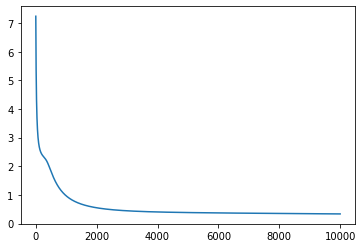

In [0]:
model.plot_error()

In [0]:
results = {}

params = {'embedding_dim':[25,30,35,40,50], 'learn_rate':[0.1,5,10,15]}

for k,v in params.items():

    if k=='embedding_dim':

        adadelta_results[k] = {}

        for dim in params[k]:
            model = MFModel(ratings_df=ratings, num_iterations=2000,embedding_dim=dim,optimizer='adadelta')
            model.train()
            error_dict = model.get_error_dict()
            
            adadelta_results[k][dim] = np.min(error_dict['test_error'])

    else:
        continue
